# Préliminaire : Installation de bibliothèques

In [2]:
!pip install yfinance
!pip install pandas_datareader

# Etape 1 : Importations de fonctions/bilbliothèques et téléchargement des données d'une action (ici Apple)

### Importation de fonctions et bibliothèques utiles

In [11]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from numpy.linalg import LinAlgError
import pandas_datareader.data as web
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
sns.set_style('whitegrid')

### Nous allons étudier l'action Apple

In [12]:
action_nom = 'AAPL'
action_df = yf.download(tickers=action_nom, start='2012-01-01', end='2023-01-29')
action_df.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449691,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516599,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655557,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787854,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767571,394024400


### On récupère la différence du log de l'action lors de la fermeture ajusté
il s'agit du Log du retour d'investisemment d'un jour à l'autre

In [13]:
action_log = np.log(action_df['Adj Close']).diff().dropna()
action_log

Date
2012-01-04    0.005360
2012-01-05    0.011041
2012-01-06    0.010399
2012-01-09   -0.001587
2012-01-10    0.003574
                ...   
2023-01-23    0.023229
2023-01-24    0.010013
2023-01-25   -0.004712
2023-01-26    0.014695
2023-01-27    0.013591
Name: Adj Close, Length: 2785, dtype: float64

# Etape 2 : Plot d'un corrélogramme

### On définit la fonction du correlogramme

In [14]:
def plot_correlogramme(x, lags=None, title=None):
    if lags is None:
        lags = min(10, int(len(x)/5))
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q_stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1,2,3,4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=0.02, y=0.75, s=s, transform=axes[0][1].transAxes)
    u=acf(x)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x=x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('lag')
    axes[1][1].set_xlabel('lag')
    axes[1][0].set_ylim(min(u[1:]-0.05),max(u[1:])+0.05)
    axes[1][1].set_ylim(min(u[1:]-0.05),max(u[1:])+0.05)
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    return

### On trace le corrélogramme pour du Log du retour d'investissemennt d'un jour à l'autre

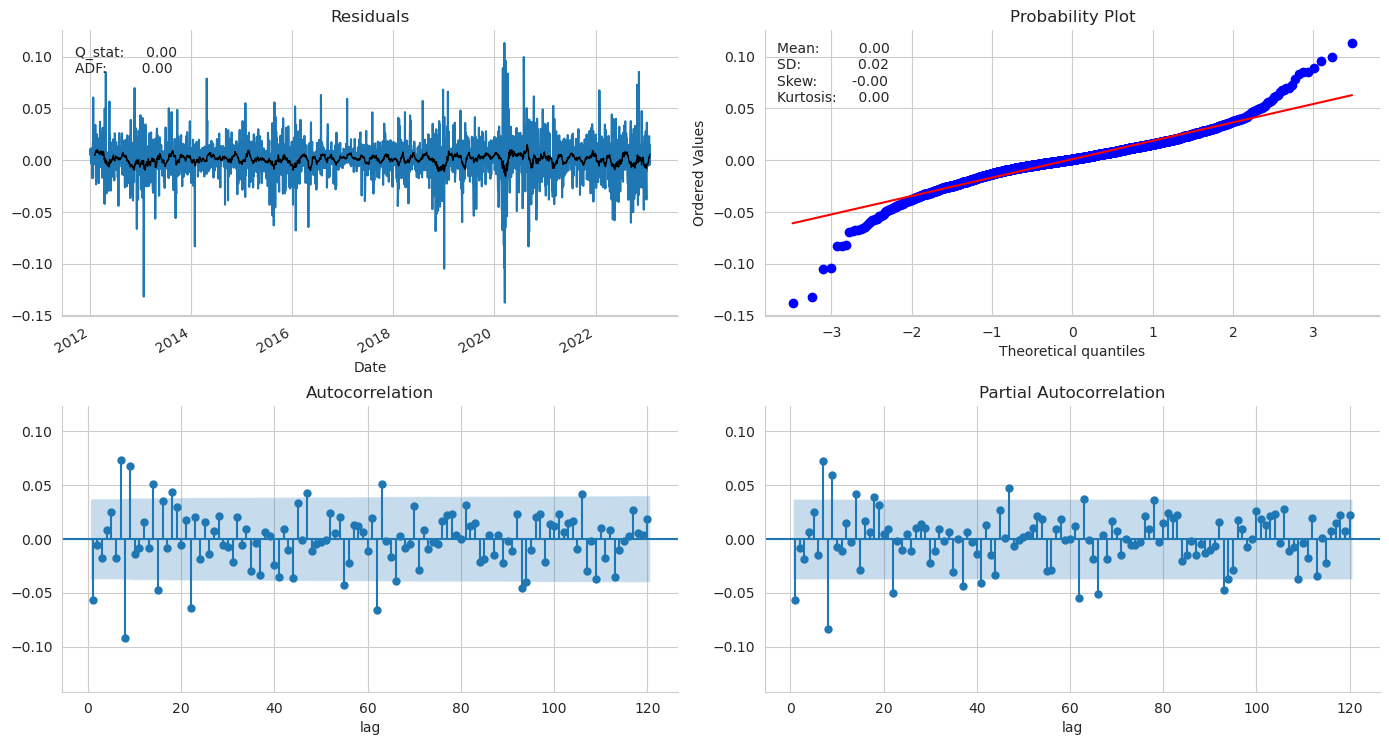

In [15]:
plot_correlogramme(x=action_log,lags=120,title=None)

#### Variation à priori aléatoire

### On trace le corrélogramme de la volatilité journalière

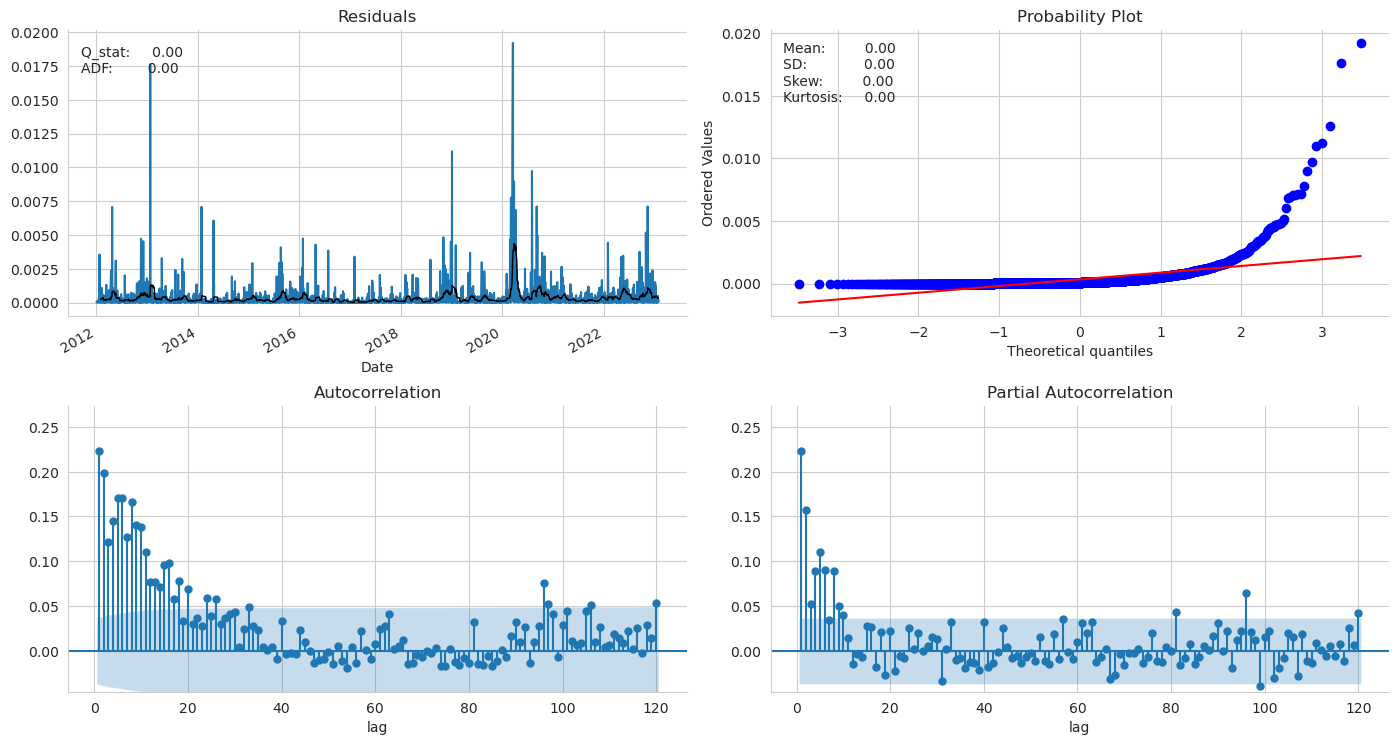

In [16]:
action_vol_j = (action_log - action_log.mean())**2
plot_correlogramme(x=action_vol_j,lags=120,title=None)

#### Contrairement aux variations aléatoire de l'autocorrélation du log du retour d'investissement quotidien, on remarque une décroissance bien dessiné de l'autocorrélation de la volatilité journalière. Ce comportement va nous permettre de prédire selon un modèle GARCH la volatilité des jours futurs

# Etape 3 : Prédication de la volatilité grâce au modèle GARCH

### Fit des résultats selon différents ordre (p,q)

In [17]:
!pip install arch

In [24]:
from arch import arch_model

trainsize = 10*252

data = action_log.clip(lower=action_log.quantile(0.05), upper=action_log.quantile(0.95))

T=len(action_log)

resultats = {}

for p in range(1,5):
    for q in range(1,5):
        print(f'{p}｜{q}')
        resultat = []
        for s,t in enumerate(range(trainsize, T-1)):
            donnee_train = data.iloc[s:t]
            donnee_test = data.iloc[t+1]
            modele = arch_model(y=donnee_train, p=p, q=q).fit(disp='off')
            prevision = modele.forecast(horizon=1)
            mu = prevision.mean.iloc[-1,0]
            sigma= prevision.variance.iloc[-1,0]
            resultat.append([(donnee_test-mu)**2, sigma])
        df_resultat = pd.DataFrame(resultat, columns=['y_true', 'y_pred'])
        resultats[(p,q)] = np.sqrt(mean_squared_error(df_resultat.y_true, df_resultat.y_pred))

1｜1
1｜2
1｜3
1｜4
2｜1
2｜2
2｜3
2｜4
3｜1
3｜2
3｜3
3｜4
4｜1
4｜2
4｜3
4｜4


In [25]:
resultats

{(1, 1): 0.00030189737043050406,
 (1, 2): 0.0003026715693696708,
 (1, 3): 0.00030215187252658816,
 (1, 4): 0.00030260482847735117,
 (2, 1): 0.000301679080675253,
 (2, 2): 0.00030187110506795493,
 (2, 3): 0.00030188823936379164,
 (2, 4): 0.0003022122620181527,
 (3, 1): 0.000301253641002715,
 (3, 2): 0.00030159055302937286,
 (3, 3): 0.00030329827209485877,
 (3, 4): 0.0003039280704613197,
 (4, 1): 0.0003010154673762542,
 (4, 2): 0.0003010240067815906,
 (4, 3): 0.0003023760907834493,
 (4, 4): 0.000302431434650357}

### Recherche du meilleur modèle

In [35]:
best_order = min(resultats,key=resultats.get)

print(best_order)

(4, 1)


In [33]:
best = arch_model(y=data, p=best_order[0], q=best_order[1]).fit(update_freq=5, disp='off')

print(best)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7956.97
Distribution:                  Normal   AIC:                          -15899.9
Method:            Maximum Likelihood   BIC:                          -15858.4
                                        No. Observations:                 2785
Date:                Mon, Dec 04 2023   Df Residuals:                     2784
Time:                        11:23:41   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.2380e-03  2.487e-04      4.978  6.429e-07 [7.

### Prédiction un jour après

In [48]:
data = action_log.to_frame('action_log_ret_q')
data['variance'] = data['action_log_ret_q'].rolling(70).var()
data = data['2020':]
data

,action_log_ret_q,variance
Date,,
2020-01-02,0.022560,0.000131
2020-01-03,-0.009770,0.000133
2020-01-06,0.007937,0.000131
2020-01-07,-0.004714,0.000131
2020-01-08,0.015958,0.000132
...,...,...
2023-01-23,0.023229,0.000592
2023-01-24,0.010013,0.000593
2023-01-25,-0.004712,0.000577


In [55]:
def prediction_vol(x):
    best_m = arch_model(y=x, p=best_order[0], q=best_order[1]).fit(update_freq=5, disp='off')
    variance_pred = best_m.forecast(horizon=1).variance.iloc[-1,0]
    #print(x.index[-1])
    return variance_pred

data['predictions'] = data['action_log_ret_q'].rolling(70).apply(lambda x: prediction_vol(x))
data = data.dropna()
data

/opt/mamba/lib/python3.10/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,action_log_ret_q,variance,predictions
Date,,,
2020-07-21,-0.013898,0.000301,0.000280
2020-07-22,0.002805,0.000298,0.000245
2020-07-23,-0.046585,0.000306,0.000361
2020-07-24,-0.002480,0.000304,0.001587
2020-07-27,0.023424,0.000310,0.000413
...,...,...,...
2023-01-23,0.023229,0.000592,0.000556
2023-01-24,0.010013,0.000593,0.000556
2023-01-25,-0.004712,0.000577,0.000448


<module 'matplotlib.pyplot' from '/opt/mamba/lib/python3.10/site-packages/matplotlib/pyplot.py'>

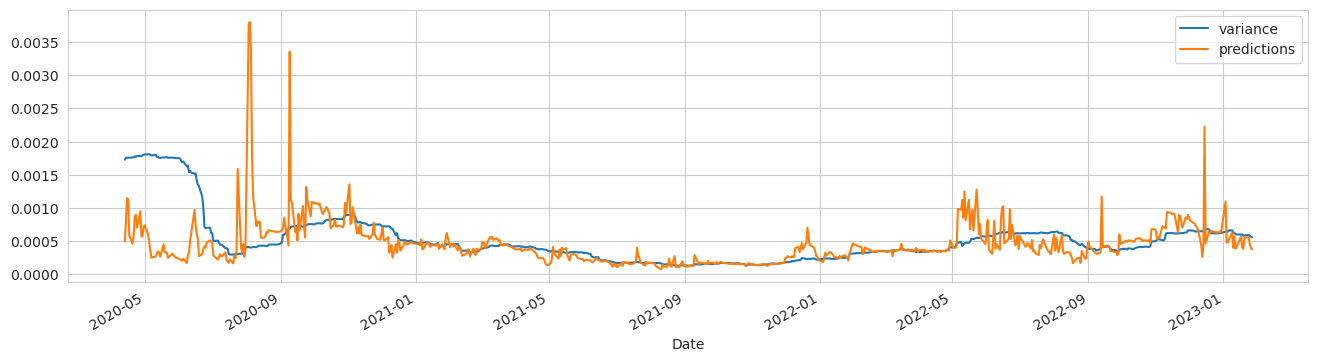

In [54]:
data[['variance', 'predictions']].plot(figsize=(16,4))
plt